In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [3]:
data1 = loadmat('../Data/ex3data1.mat')

In [4]:
data1

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [51]:
data1['X'][0].shape

(400,)

In [29]:
import time
from IPython.display import clear_output

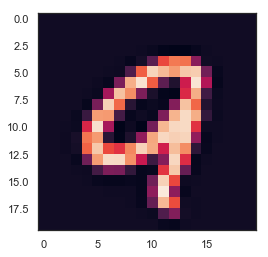

In [52]:
for i in range(0,data1['X'].shape[0],100):
    clear_output(wait=True)
    ih = plt.imshow(data1['X'][i].reshape(20,20).T)
    plt.show()
    time.sleep(1/1000)

In [9]:
data1['X'].shape

(5000, 400)

In [41]:
y = data1['y']

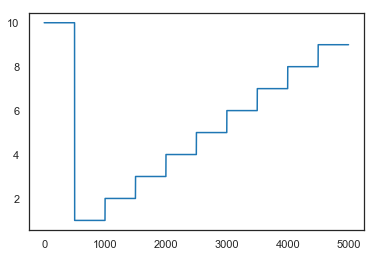

In [47]:
plt.plot(y)

Why is 0 represented as 10?

Edit: Instructions say this is b/c matlab has no zero-indexing. That's not a problem here.

In [48]:
y[y==10] = 0

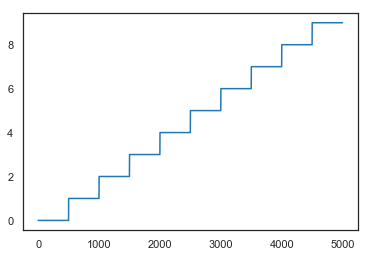

In [49]:
plt.plot(y)

Now to vectorize the regression functions that I've built. There's really no reason that I haven't done this yet. I'm already halfway there.

In [75]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def costFunctionRegularization(X,y,thetas, lamda): #intentional misspelling of lamda
    m = y.size
    z = X@thetas
    J = (1/m)*(-(y.T@np.log(sigmoid(z)))-((1-y).T@np.log(1-sigmoid(z)))) + (lamda/(2*m))*thetas.T@thetas
    return J[0]

def gradientDescentRegularization(X, y, alpha = 0.01, lamda = 1, iterations = 1000):
    m = y.size
    num_j = X.shape[1]
    thetas = np.zeros((num_j,1))
    new_thetas = np.zeros_like(thetas)
    J_list = []
    for _ in range(iterations):
        grad = X.T@(sigmoid(X@thetas) - y) + lamda*thetas*(np.c_[np.arange(num_j)]>=1)
        new_thetas = thetas - (alpha/m)*grad
        J_list.append(costFunctionRegularization(X,y,thetas,lamda))
        thetas = new_thetas
    return thetas, J_list

In [62]:
X = data1['X']
X = np.c_[np.ones((X.shape[0],1)), X]

In [63]:
values = np.unique(y)

In [303]:
thetas = {val: np.zeros((X.shape[1],1)) for val in values}
iterations = 500
J_list = {val: np.zeros((1,iterations)) for val in values}
for val in values:
    yOneHot = np.ones_like(y)*(y==val)
    thetas[val], J_list[val] = gradientDescentRegularization(X, yOneHot, alpha = 1, lamda = .01, iterations = iterations)

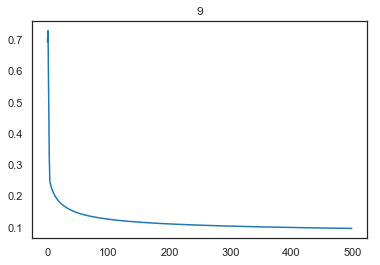

In [304]:
for val in values:
    clear_output(wait=True)
    plt.plot(J_list[val])
    plt.title(val)
    plt.show()
    time.sleep(1/2)

## These two cells do not run the same each time. They seem to converege to the right answer after successive runs. I don't get it. In the beginning, negative values appear on the scatter plot, but the more I run it, they evetually go away. Usually after 2-3 runs it because stable.

In [460]:
yProb = np.empty((y.size,1))
for val in values:
    yProb = np.append(yProb,sigmoid(X@thetas[val]),axis=1)
yGuess = yProb.argmax(axis=1)-1

print(f'The success rate is {100*sum(y==np.c_[yGuess])[0]/y.size}%')

The success rate is 92.14%


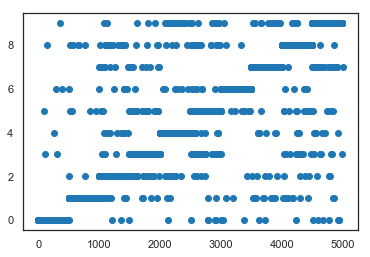

In [442]:
plt.scatter(np.arange(len(yGuess)),yGuess)
plt.show()

Still, I'm not getting the percentage that has been advertized. Let's try scikit-learn's regression.

In [332]:
from sklearn.linear_model import LogisticRegression

In [334]:
lr = {val: LogisticRegression(solver='lbfgs', max_iter=1000, tol=1e-6, C=1) for val in values}
for val in values:
    yOneHot = np.ones_like(y)*(y==val)
    lr[val].fit(X[:,1:], yOneHot.ravel())
    print(f'Number of iterations: {lr[val].n_iter_[0]}')

Number of iterations: 80
Number of iterations: 65
Number of iterations: 98
Number of iterations: 108
Number of iterations: 85
Number of iterations: 105
Number of iterations: 75
Number of iterations: 86
Number of iterations: 120
Number of iterations: 110


In [443]:
yProb = np.empty((y.size,1))
for val in values:
    yProb = np.append(yProb,lr[val].predict_proba(X[:,1:])[:,1].reshape(-1,1),axis=1)
yGuess = yProb.argmax(axis=1)-1
print(f'The success rate is {100*sum(y==np.c_[yGuess])[0]/y.size}%')

The success rate is 94.46%


This looks closer to what the instruction sheet expects me to achieve. And further experimentation makes it seem like the scatter plot is the culprit in making things not work out, which is why I haven't included it here. I'm guessing it moves some things around in memory? I don't see why it would, though.

### I think there's an even easier way to do this without one-hot encoding

In [468]:
lr = LogisticRegression(solver = 'lbfgs', max_iter = 1000, tol = 1e-4, C =1, multi_class='multinomial')
lr.fit(X[:,1:],y.ravel())
print(f'Number of iterations: {lr.n_iter_[0]}')

yGuess = lr.predict(X[:,1:])

print(f'The success rate is {100*sum(y==np.c_[yGuess])[0]/y.size}%')

Number of iterations: 213
The success rate is 96.24%


So not only is it easier, but it's also better.

# Onto the next part!

In [469]:
weights = loadmat('../Data/ex3weights.mat')
weights

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Oct 18 14:57:02 2011',
 '__version__': '1.0',
 '__globals__': [],
 'Theta1': array([[-2.25623899e-02, -1.05624163e-08,  2.19414684e-09, ...,
         -1.30529929e-05, -5.04175101e-06,  2.80464449e-09],
        [-9.83811294e-02,  7.66168682e-09, -9.75873689e-09, ...,
         -5.60134007e-05,  2.00940969e-07,  3.54422854e-09],
        [ 1.16156052e-01, -8.77654466e-09,  8.16037764e-09, ...,
         -1.20951657e-04, -2.33669661e-06, -7.50668099e-09],
        ...,
        [-1.83220638e-01, -8.89272060e-09, -9.81968100e-09, ...,
          2.35311186e-05, -3.25484493e-06,  9.02499060e-09],
        [-7.02096331e-01,  3.05178374e-10,  2.56061008e-09, ...,
         -8.61759744e-04,  9.43449909e-05,  3.83761998e-09],
        [-3.50933229e-01,  8.85876862e-09, -6.57515140e-10, ...,
         -1.80365926e-06, -8.14464807e-06,  8.79454531e-09]]),
 'Theta2': array([[-0.76100352, -1.21244498, -0.10187131, -2.36850085, -1.057781

In [470]:
theta1 = weights['Theta1']
theta2 = weights['Theta2']

In [474]:
theta1.shape

(25, 401)

In [473]:
X.shape

(5000, 401)

In [472]:
theta2.shape

(10, 26)

In [478]:
a2 = sigmoid(X@theta1.T)

In [479]:
a2 = np.c_[np.ones((a2.shape[0],1)),a2]

In [480]:
a2.shape

(5000, 26)

In [481]:
a3= sigmoid(a2@theta2.T)

In [483]:
yGuess = a3.argmax(axis=1)

<function matplotlib.pyplot.show(*args, **kw)>

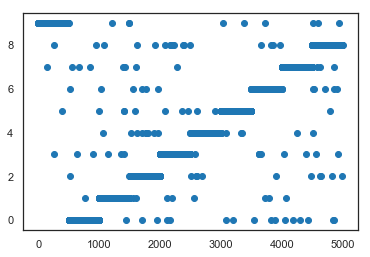

In [487]:
plt.scatter(np.arange(len(yGuess)),yGuess)
plt.show

In [488]:
yGuess+=1
yGuess[yGuess==10]=0

In [489]:
print(f'The success rate is {100*sum(y==np.c_[yGuess])[0]/y.size}%')

The success rate is 97.52%


That was pretty easy. It's easy to understand how the feed forward works. Manual back-propogation might be trickier, but I feel like it's just the same as logisitic regression, but this time there are layers.